In [1]:
%matplotlib inline
import sys
sys.path.append("..")

In [2]:
import random

import deeptrack as dt

import numpy as np
import skimage.color
import matplotlib.pyplot as plt
import tensorflow as tf

tracker_input_size = 64


In [3]:
class AutoOrienterGenerator(dt.generators.AutoTrackGenerator):
    def __getitem__(self, idx):

        X, (_, transform) = super().__getitem__(idx)
        offset = np.zeros((X.shape[0], 1, 1))
        
        return X, (offset, transform)

class AutoOrienter(dt.models.AutoTracker):
    
    class AutoTrackerModel(dt.models.AutoTrackerBaseModel):
        def call(self, x, training=False):
            y = super().call(x)

            cosy, siny = tf.split(y, 2, axis=-1)
            R = tf.sqrt(tf.square(cosy) + tf.square(siny))
            cosy = cosy / R
            siny = siny / R
            
            if training:
                out = tf.concat((cosy, siny, -siny, cosy), axis=-1)
                out = tf.reshape(out, (-1, 2, 2))
                return out, R - 1

            else:
                return tf.atan2(siny, cosy)

    def default_model(self, input_shape):

        return dt.models.Convolutional(
            input_shape=input_shape,
            conv_layers_dimensions=[32, 64, 128],
            dense_layers_dimensions=(32, 32),
            steps_per_pooling=1,
            number_of_outputs=2,
        )

    def data_generator(self, *args, **kwargs):

        transformation_function = dt.Affine(
            translate=lambda: np.random.randn(2) *2, 
            rotate=lambda: np.random.rand() * np.pi * 2,
        )

        return AutoOrienterGenerator(
            transformation_function, *args, symmetries=self.symmetries, **kwargs
        )


In [4]:
class CrescentMoon(dt.Ellipse):
    def get(self, *inp, radius, offset, **kwargs):
        ellipse = super().get(*inp, radius=radius, **kwargs)
        offset = np.round(offset).astype(np.int)
        other = dt.Affine(translate=offset, mode="constant").resolve(ellipse)
        ellipse[np.array(other > 0)] = 0
        
        return ellipse
        
class Rectangle(dt.Scatterer):
    def get(self, *inp, width, height, **kwargs):
        return np.ones((round(width), round(height), 1))
        

In [5]:

commons = dt.DummyFeature(
    image_size=tracker_input_size,
    position=lambda image_size: image_size / 2 + np.random.randn(2) * 2
)

arguments = dt.Arguments(
    noise_level=lambda: 2 + np.random.rand() * 18,
    key=lambda: np.random.choice(["moon", "rect", "ellipse"]),
)

fluorescence_microscope = dt.Fluorescence(
    NA=0.8,                
    resolution=1e-6,     
    magnification=10,
    wavelength=680e-9,
    output_region=(0, 0, tracker_input_size, tracker_input_size)
)

noise = dt.Poisson(snr=arguments.noise_level, background=0.2)

u = dt.units
moon_particle = CrescentMoon(radius=1e-6, offset=(6, 0), position=commons.position)
rectangle_particle = Rectangle(height=18, width=12, position=commons.position)
ellipse_particle = dt.Ellipse(radius=np.array((1, 1)) * u.um, position=commons.position)

particles = {
    "moon": moon_particle,
    "rect": rectangle_particle,
    "ellipse": ellipse_particle
}

particle = dt.OneOfDict(particles, key=arguments.key)

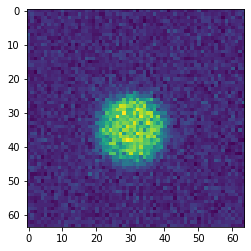

In [6]:


pipeline = (
    fluorescence_microscope(particle)
    >> dt.Affine(rotate=lambda:np.random.rand()*2*np.pi)
    >> dt.NormalizeMinMax() 
    + 0.2
) >> noise >> dt.NormalizeMinMax()

pipeline.bind_arguments(arguments)
pipeline.update().plot()

In [7]:
dataset = [pipeline.update().resolve() for _ in range(1000)]
dataset_labels = [np.mean(d.get_property("rotate", get_one=False), axis=0) for d in dataset]

In [21]:
symmetries = 2
key = "rect"
noise_level = 10

model = AutoOrienter(
    input_shape=(tracker_input_size, tracker_input_size, 1),
    mode="orientation",
    symmetries=symmetries,
    loss="mse"
)


model_data = dt.Value(pipeline.update().resolve(key=key, noise_level=noise_level))
model.fit(model_data, epochs=20, batch_size=8)



Generating 800 / 400 samples before starting training
Epoch 1/20
800/800 [==============================] - 6s 6ms/step - loss: 0.7788 - constraint_0: 0.0372
Epoch 2/20
800/800 [==============================] - 5s 6ms/step - loss: 0.0223 - constraint_0: 0.0098
Epoch 3/20
800/800 [==============================] - 5s 7ms/step - loss: 0.0124 - constraint_0: 0.0031
Epoch 4/20
800/800 [==============================] - 5s 7ms/step - loss: 0.0036 - constraint_0: 0.0017
Epoch 5/20
800/800 [==============================] - 5s 6ms/step - loss: 0.0080 - constraint_0: 0.0021
Epoch 6/20
589/800 [=====================>........] - ETA: 1s - loss: 0.0023 - constraint_0: 7.9830e-04

KeyboardInterrupt: 

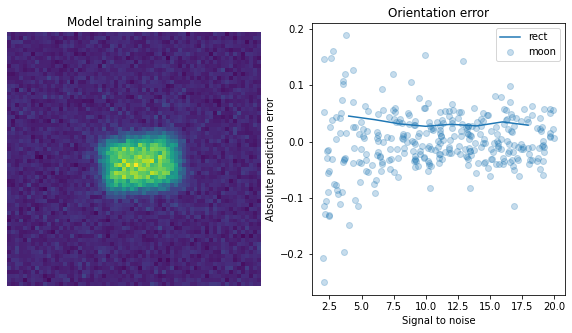

In [24]:

classification = [d.get_property("key") for d in dataset]
classes = set(classification)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(model_data())
plt.axis("off")
plt.title("Model training sample")

plt.subplot(1, 2, 2)

for cl in ["rect"]:

    indexes = np.array(classification) == cl

    predicted_angle = model.predict(np.array(dataset))[indexes, 0]
    predicted_angle_2 = model.predict(np.array(dataset)[:, ::-1])[indexes, 0]

    angle = predicted_angle / symmetries
    angle_2 = predicted_angle_2 / symmetries


    _dataset_labels = np.array(dataset_labels)[indexes]

    diff = angle - _dataset_labels

    diff = (diff + 0.5 * np.pi / symmetries) % (2 * np.pi / symmetries)
    diff = diff - np.mean(diff)

    xraw = np.array([d.get_property("snr") for d in dataset])[indexes]

    plt.scatter(xraw, diff, alpha=.25)
    vmin = np.min(xraw)
    vmax = np.max(xraw)
    x = np.linspace(vmin, vmax, 10)

    _x = xraw
    _y = np.abs(diff)

    y = [np.mean( _y[(_x >= x[i]) & (_x < x[i+1]) ]) for i in range(9)]
    plt.plot(x[1:9], y[1:9])
plt.title("Orientation error")
plt.ylabel(f"Absolute prediction error")
plt.xlabel(f"Signal to noise")

plt.legend([x for x in classes])
plt.show()


In [10]:
predicted_angle.shape

(332,)